In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [2]:
def splitTrainTest(dataset, y, split=0.60):
    """ 
    Separating the dataset into 2 parts: Training Dataset (to train the model) & Test Dataset (to evaluate the performance of the model)
    The rows assigned to each dataset are randomly selected (to ensure that the model is objective).
    randrange() generate a random integer in the range between 0 and the size of the list.

    Parameters:
        dataset: The dataset to split as a list of lists
        split: Split percentage. (default split = 60%) --> A 60/40 for train/test
        
    Returns:
        train: 60% of the dataset
        test: The rows that remain in the copy of the dataset are then returned as the test dataset. (40%)
    """

    #calculate how many rows the training set requires
    xTrain = pd.DataFrame()
    yTrain = pd.DataFrame()
    trainSize = split * len(dataset)
    datasetCopy = dataset.copy()
    yCopy = y.copy()

    #add index column
    datasetCopy.reset_index(inplace=True)
    datasetCopy = datasetCopy.rename(columns={"index": "index"})
    yCopy.reset_index(inplace=True)
    yCopy = yCopy.rename(columns={"index": "index"})

    idxRan = len(datasetCopy)
    while len(xTrain) < trainSize: # while until the train dataset contains the target number of rows.
        randomIndex = np.random.choice(datasetCopy.index, 1, replace=False) #select random rows

        datasetCopy = datasetCopy.drop(datasetCopy["index"][randomIndex]) #remove random rows from the datasetCopy
        yCopy = yCopy.drop(yCopy["index"][randomIndex]) #remove random rows from the datasetCopy

        xTrain = pd.concat([xTrain, dataset.loc[randomIndex]]) #add rows to train dataset
        yTrain = pd.concat([yTrain, y.loc[randomIndex]]) #add rows to train dataset
        idxRan = idxRan - 1
    
    datasetCopy = datasetCopy.drop(labels=["index"], axis=1)
    yCopy = yCopy.drop(labels=["index"], axis=1)
    return xTrain, datasetCopy, yTrain, yCopy

In [3]:
def getData():
    """
    Args:
        file (str, optional): Location of Iris.csv file. Defaults to 'Iris.csv'.
        binary_version (bool, optional): Select if binary labels are used. Defaults to True.
            target variable will select the positive label.

    Returns:
        array: Features and labels in the las column.
        dict: Encodig of labels to string.
    """
    iris = datasets.load_iris()
    df = pd.DataFrame(iris.data, columns = iris.feature_names)
    y = pd.DataFrame(iris.target, columns = ["Target"])

    xTrain, xTest, yTrain, yTest = splitTrainTest(df,y)

    return xTrain, xTest, yTrain, yTest

In [4]:
class StandarScaler:
    """ 
    Standardize features by removing the mean and scaling to unit variance. 
    z = (x - MEAN) / DESV EST 
    """
    def __init__(self):
        pass

    def fit(self, X):
        X = pd.DataFrame(X)
        self.mean = X.mean(axis = 0).to_numpy()
        self.std = X.std(axis = 0).to_numpy()
        
    def transform(self, X):
        X -= self.mean
        X /= self.std
        return X 
    
    def fitTransform(self, X):
        self.fit(X)
        df = self.transform(X)
        return df 

In [5]:
def oneHot(y):
    """
    Converts the training data into a series of ones and zeros for the classes given.
    """
    yEncoded = np.zeros(shape=(y.size, int(y.max()[0])+1))
    y = y.Target.tolist()
    for i in range(len(y)): # rows
        yEncoded[i,y[i]] = 1 # sub fila, sub columna que diga y
    return yEncoded

In [6]:
class MultiLogisticReg():
    def __init__(self):
        pass

    def softMaxFunc(self, z):
        # sigm = []
        # for i in range(len(z)):
        #     lista = np.exp(z[i])/sum(np.exp(z[i]))
        #     sigm.append(lista.tolist())
        sigm = np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)
        return sigm
    
    def getWeights(self,X,y):
        cantTargs = np.shape(y)[1]
        feats = np.shape(X)[1] # columnas 
        weight = np.random.rand(feats, cantTargs) # array FEATURE * CLASES
        b = np.ones(cantTargs)
        return weight, b

    def fit(self,X,y, rounds = 1000, lRate=0.1):
        """
        weighted sum of the inputs plus a bias term 
        For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ 
        handle multinomial loss; SOFTMAX
        """

        self.weight, self.bias = self.gradientDescent(rounds, lRate, X, y)
            
    def gradientDescent(self, rounds, lRate, X, y):
        weight, bias = self.getWeights(X, y)
        rows = X.shape[0]
        count = 0
        # later we graph the loss
        losses = [] 
        roundL = []

        while count < rounds:
            z = np.dot(X, weight) + bias # (w·x)
            yG = self.softMaxFunc(z) # yˆ = σ(w·x) Ya son probs
            gradient = 1/rows * np.dot(X.T, (yG - y))
            #updtate a lo weights
            weight -= lRate * gradient
            bias -= lRate * np.sum((yG - y))
            count += 1 

            loss = self.lossFunction(z, y) # loss entre ygorrito y y train
            losses.append(loss)
            roundL.append(count)

        self.df = pd.DataFrame({
                'Round': roundL, 
                'Loss': losses
        })

        return weight, bias

    def lossFunction(self, z, y):
        """
        Calculate log negative likelihood (loss)
        The loss increases as the predicted probability diverge from the actual label.

        Parameters:
        yG:
        y:

        Returns:
        loss: Average loss
        """

        # Y must be one-hot encoded
        rows = y.shape[0]
        loglLoss = -1/rows * (np.trace(np.dot(z, y.T)) + np.sum(np.log(np.sum(np.exp(z), axis=1))))
        return loglLoss
    
    def visualizeLoss(self):
        return self.df.plot(
            x='Round', 
            y='Loss',
            xlabel='Round',
            ylabel='Loss'
        )

    def predict(self, X):
        z = np.dot(X, self.weight) + self.bias
        probs = self.softMaxFunc(z)
        predictions = np.argmax(probs, axis=1)
        return predictions

    def predictProba(self, X):
        z = np.dot(X, self.weight) + self.bias
        probs = self.softMaxFunc(z)
        return probs

In [7]:
xTrain, xTest, yTrain, yTest = getData()

In [8]:
ss = StandarScaler()

xTrain = ss.fitTransform(xTrain)
xTest = ss.fitTransform(xTest)

In [9]:
yTrain = oneHot(yTrain)

In [10]:
mlr = MultiLogisticReg()

In [11]:
mlr.fit(xTrain, yTrain)

<AxesSubplot:xlabel='Round', ylabel='Loss'>

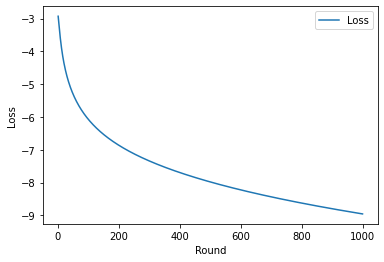

In [16]:
mlr.visualizeLoss()

In [12]:
yPred = mlr.predict(xTest)
yProbs = mlr.predictProba(xTest)

In [13]:
yPred = yPred.tolist()
yTest = yTest.Target.tolist()

In [14]:
def metrics(yTest, yPred):
    cnfMatrix = confusion_matrix(yTest, yPred)

    FP = (cnfMatrix.sum(axis=0) - np.diag(cnfMatrix)).astype(float) 
    FN = (cnfMatrix.sum(axis=1) - np.diag(cnfMatrix)).astype(float)
    TP = (np.diag(cnfMatrix)).astype(float)
    TN = (cnfMatrix.sum() - (FP + FN + TP)).astype(float)

    #accuracy
    accuracy = (TP + TN)/(FP + FN + TP + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1score = (2 * precision * recall) / (precision + recall)

    return (print("Accuracy", accuracy, "\n\nPrecision", precision, "\n\nRecall", recall, "\n\nF1 score", f1score))

In [15]:
metrics(yTest, yPred)

Accuracy [1.  0.9 0.9] 

Precision [1.         0.88235294 0.83333333] 

Recall [1.         0.78947368 0.90909091] 

F1 score [1.         0.83333333 0.86956522]
